Import everything

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.src.models import Sequential
from keras.src.layers import Dense, LSTM, Dropout
from keras.src.regularizers import L2
from keras.src.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

LSTM #1
This LSTM only imputes the data, it does nothing else to infuence the data or the model. In other words these are fairly standard parameters for and LSTM model.

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 122.3730 - val_loss: 94.0360
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 123.3999 - val_loss: 93.7179
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 123.5687 - val_loss: 93.3693
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 123.2898 - val_loss: 92.9515
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 121.0182 - val_loss: 92.4343
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 119.5406 - val_loss: 91.7785
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 119.4280 - val_loss: 90.9202
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 120.7878 - val_loss: 89.7819
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 118.0796 - val_loss: 88.2619
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 115.9679 - val_loss: 86.2034
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 112.6354 - val_loss: 83.3704
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step -

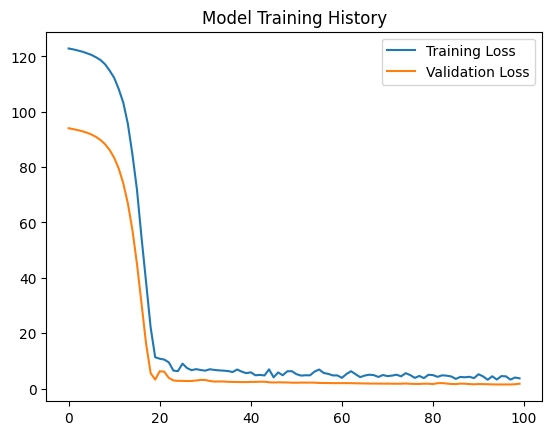

In [48]:

# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 14: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

In [49]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "MAPE"],
    "Train": [mse_train, mape_train],
    "Test": [mse_test, mape_test]
})

print("LSTM 1 Metrics: Baseline LSTM\n")
print(results)

LSTM 1 Metrics: Baseline LSTM

  Metric      Train       Test
0    MSE   1.554447   6.970352
1   MAPE  10.202990  19.342368


Visualizing RMSE for LSTM #1

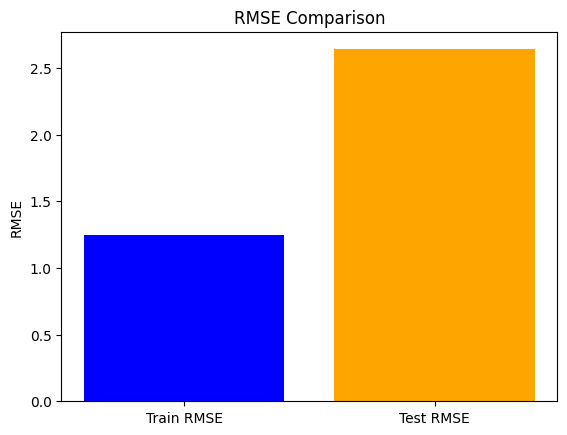

In [50]:
# Visualize RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

Test Data : Predicted vs Actual

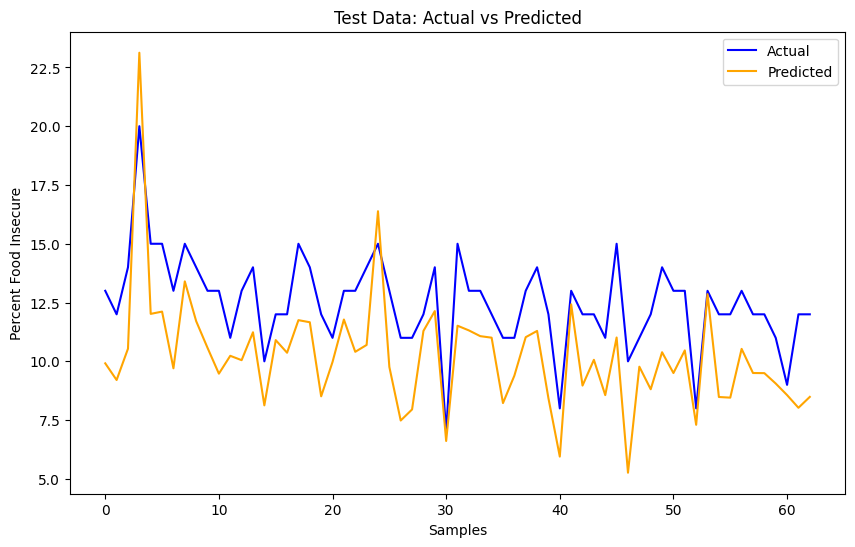

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(test_pred, label='Predicted', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Percent Food Insecure')
plt.legend()
plt.show()

Residual Analysis

Training Residuals

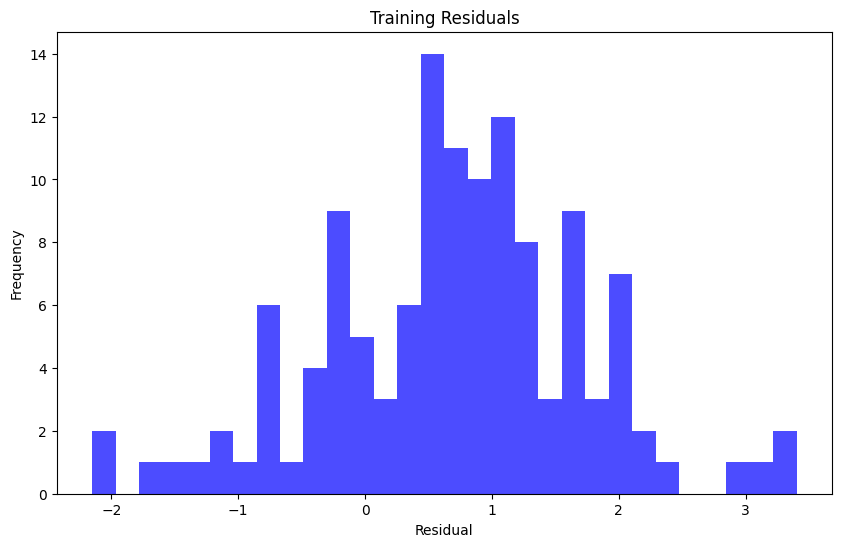

In [52]:
train_residuals = y_train - train_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(train_residuals, bins=30, color='blue', alpha=0.7)
plt.title('Training Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Test Residuals

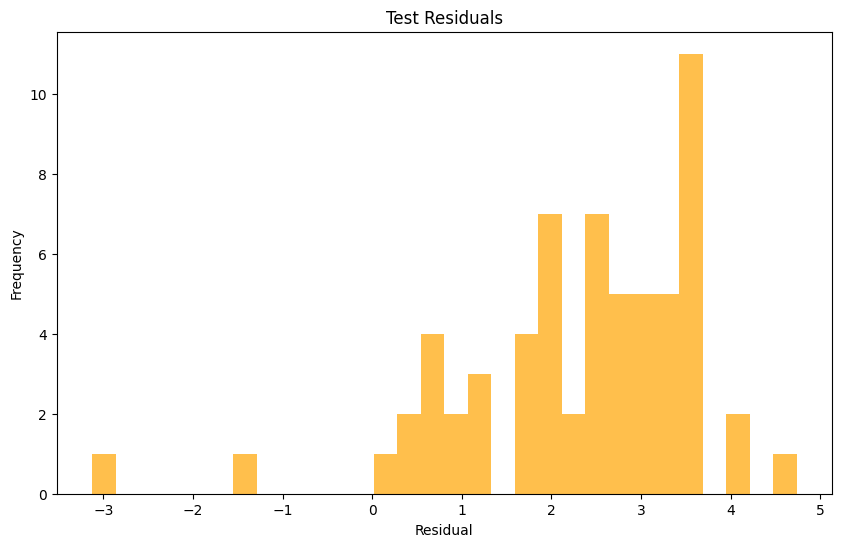

In [53]:
test_residuals = y_test - test_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(test_residuals, bins=30, color='orange', alpha=0.7)
plt.title('Test Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Training Loss Curve

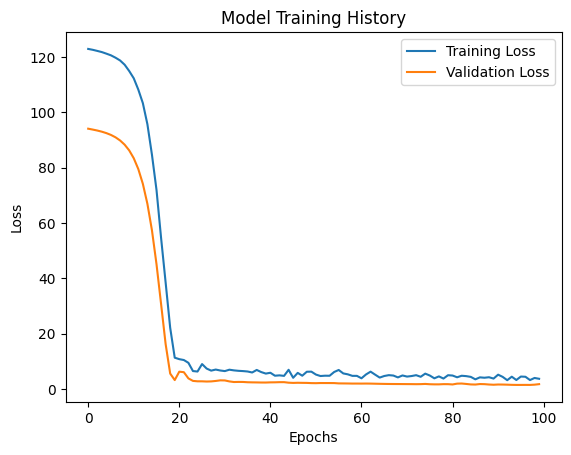

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Highest percentage yearly change in food insecurity

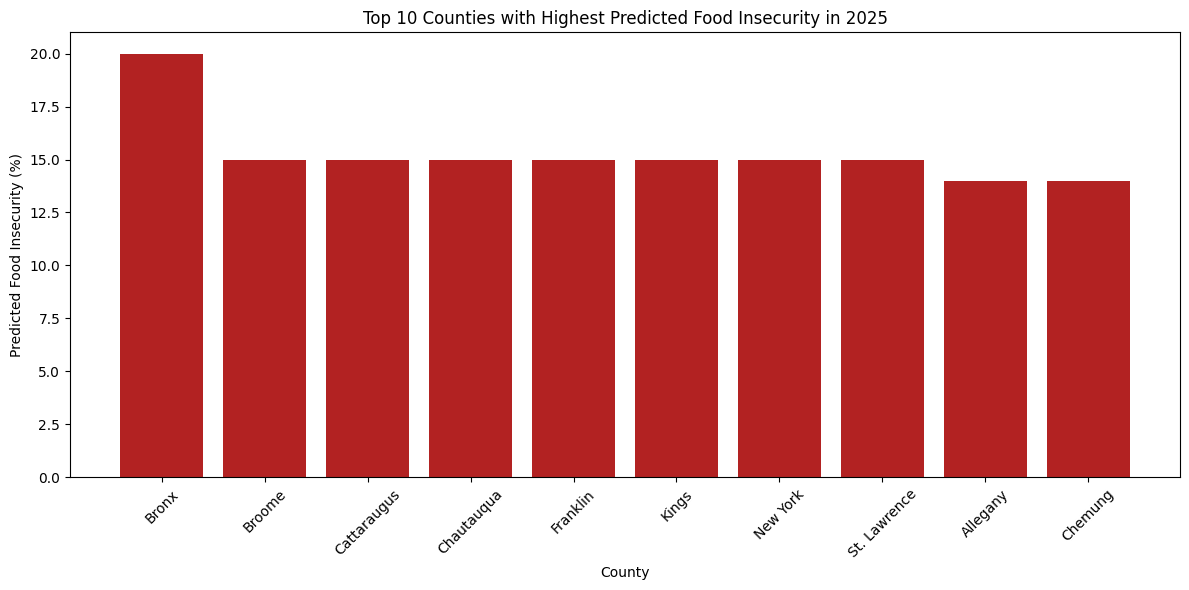

In [55]:
top_10_counties = test.nlargest(10, 'percent_food_insecure')

plt.figure(figsize=(12, 6))
plt.bar(top_10_counties['county.x'], top_10_counties['percent_food_insecure'], color='firebrick')
plt.title('Top 10 Counties with Highest Predicted Food Insecurity in 2025')
plt.xlabel('County')
plt.ylabel('Predicted Food Insecurity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Scatter Plot Analysis: Actual vs Predicted

Training Scatter

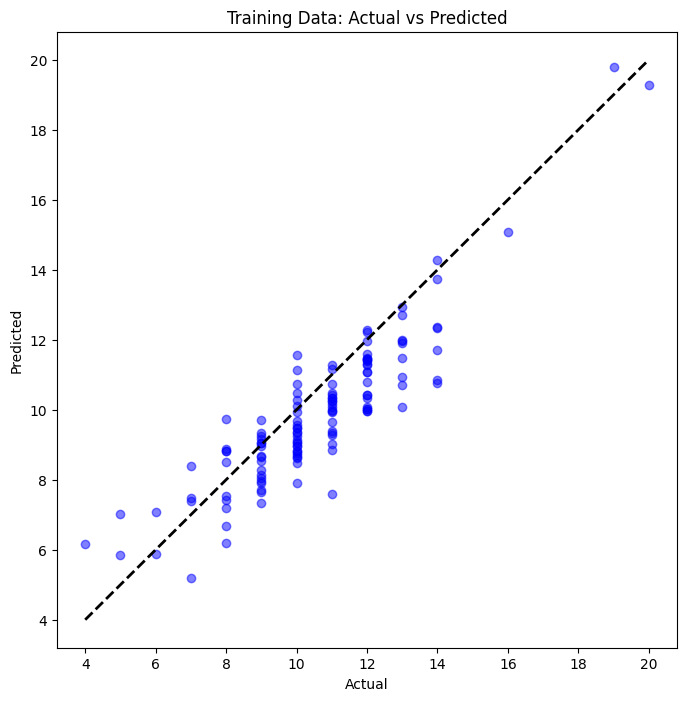

In [56]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Test Scatter

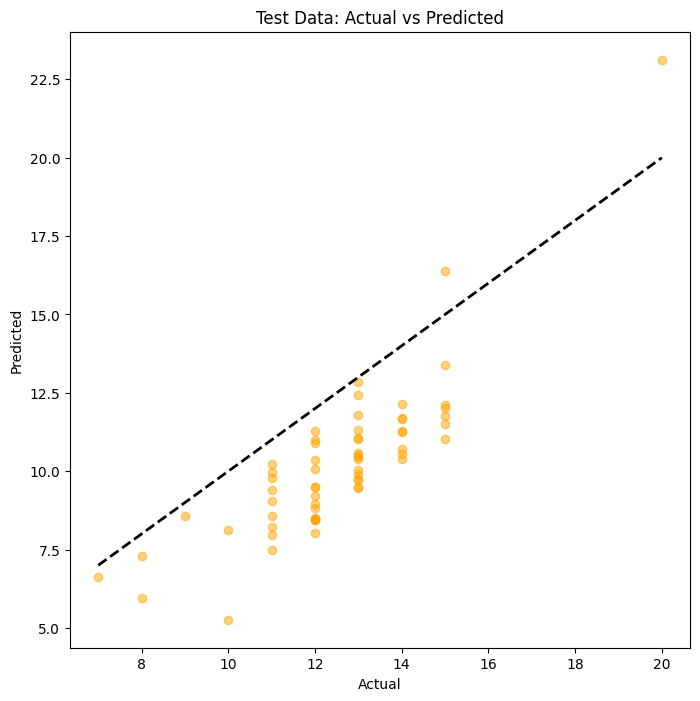

In [57]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

LSTM 2:
This LSTM model attempts to increase the amount of n_steps which will bring in more historical data into the prediction. Aiding the model in leaning temporal patterns more effectively

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 106.4360 - val_loss: 79.7519
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 106.1568 - val_loss: 79.4277
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 101.0731 - val_loss: 79.0810
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 103.8895 - val_loss: 78.6831
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 104.5410 - val_loss: 78.2012
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 103.3062 - val_loss: 77.6258
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 106.1170 - val_loss: 76.9485
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 101.0274 - val_loss: 76.1407
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 97.7061 - val_loss: 75.1659
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 100.4246 - val_loss: 73.9789
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 99.3365 - val_loss: 72.5250
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - l

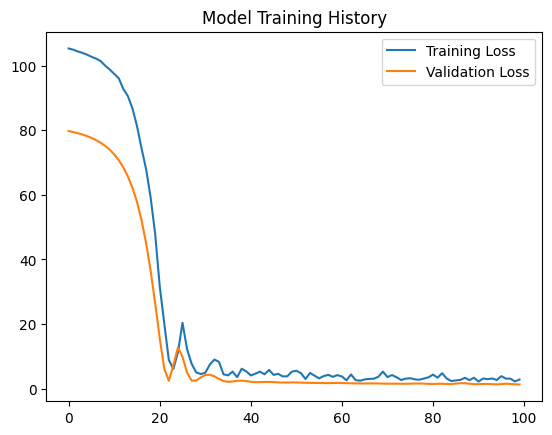

In [58]:

# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(2, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 14: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

In [59]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "MAPE"],
    "Train": [mse_train, mape_train],
    "Test": [mse_test, mape_test]
})

print("LSTM 2 Metrics: Higher n_steps\n")
print(results)

LSTM 2 Metrics: Higher n_steps

  Metric     Train       Test
0    MSE  1.014030  11.412549
1   MAPE  8.708694  25.582200


LSTM 2 : RMSE Training vs Testing 

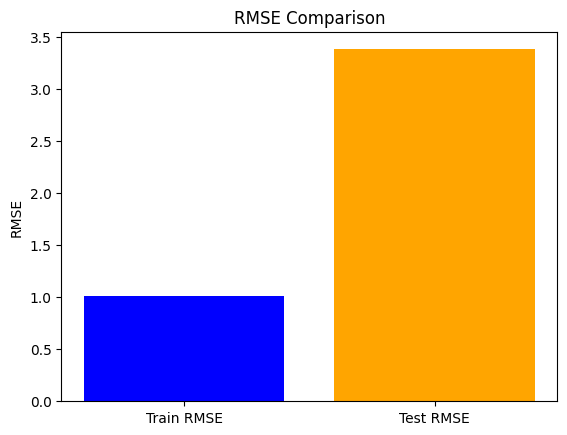

In [60]:
# Visualize RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

LSTM 2: Test Data: Predicted vs Actual

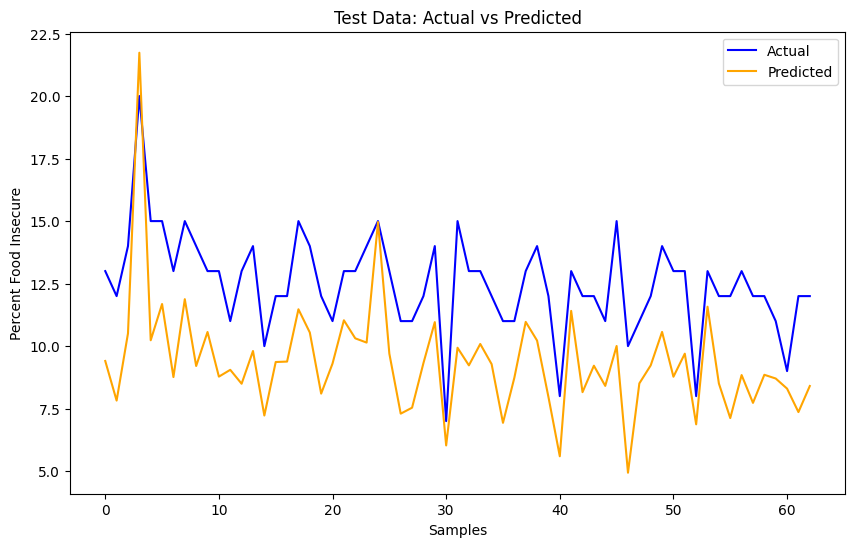

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(test_pred, label='Predicted', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Percent Food Insecure')
plt.legend()
plt.show()

Residual Analysis : LSTM 2  

Training

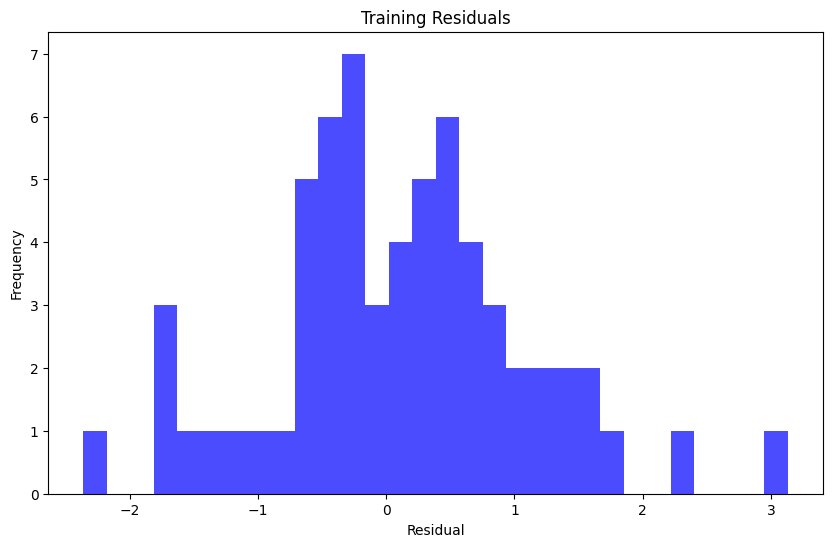

In [62]:
train_residuals = y_train - train_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(train_residuals, bins=30, color='blue', alpha=0.7)
plt.title('Training Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Testing

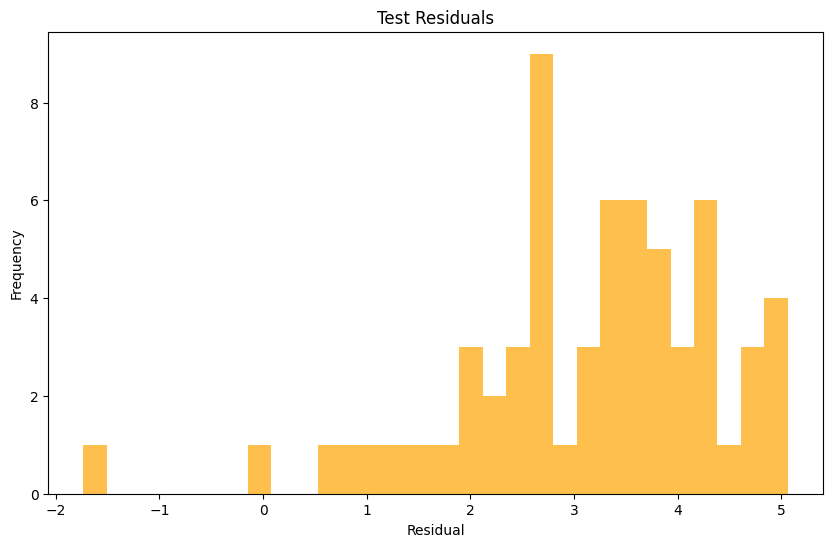

In [63]:
test_residuals = y_test - test_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(test_residuals, bins=30, color='orange', alpha=0.7)
plt.title('Test Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Experiment 3: 
- This experiment aims at introducing regularization to the data, l2 regularization from keras will be used here

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 121.7299 - val_loss: 95.1964
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 123.6746 - val_loss: 94.8082
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 125.8875 - val_loss: 94.3985
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 125.7824 - val_loss: 93.9505
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 121.2381 - val_loss: 93.4245
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 122.0321 - val_loss: 92.7692
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 120.3294 - val_loss: 91.9469
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 116.0936 - val_loss: 90.8906
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 116.8638 - val_loss: 89.5118
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 117.6295 - val_loss: 87.6928
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 119.0078 - val_loss: 85.2721
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step -

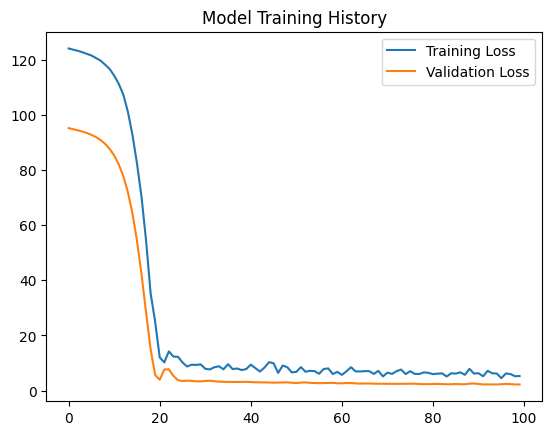

In [64]:
# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True, kernel_regularizer=L2 (0.01)),
    Dropout(0.25),
    LSTM(50, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 14: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

MAPE and MSE

In [65]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "MAPE"],
    "Train": [mse_train, mape_train],
    "Test": [mse_test, mape_test]
})

print("LSTM 3 Model Metrics: L2 Regularization, more dropout (0.2 --> 0.3)\n")
print(results)

LSTM 3 Model Metrics: L2 Regularization, more dropout (0.2 --> 0.3)

  Metric     Train       Test
0    MSE  1.100108   3.970503
1   MAPE  8.592624  13.756218


Experiment #4:
- This experiment will be introducing early stopping to try and limit the overfitting in the model

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 121.1400 - val_loss: 94.9945
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 124.5366 - val_loss: 94.4501
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 121.3449 - val_loss: 93.8145
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 123.5803 - val_loss: 93.0462
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 125.5570 - val_loss: 92.0837
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 119.1912 - val_loss: 90.8668
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 113.1644 - val_loss: 89.3087
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 112.9692 - val_loss: 87.2682
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 111.2482 - val_loss: 84.5871
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 112.5025 - val_loss: 81.0091
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 102.4062 - val_loss: 76.2353
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step -

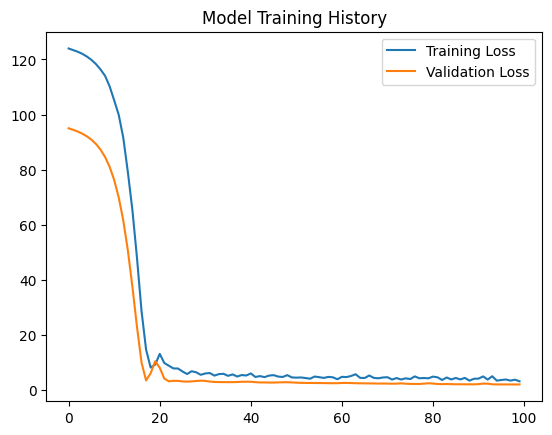

In [72]:
# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True, kernel_regularizer=L2 (0.01)),
    Dropout(0.15),
    LSTM(50, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.15),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# An early stopping callback to attempt to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,         # Stop training after 10 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
# Step 14: Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]  # Add the callback here
)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

In [73]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "MAPE"],
    "Train": [mse_train, mape_train],
    "Test": [mse_test, mape_test]
})

print("LSTM 4 Model Metrics: Early Stopping\n")
print(results)

LSTM 4 Model Metrics: Early Stopping

  Metric     Train       Test
0    MSE  1.077822   4.320335
1   MAPE  8.324163  14.714088


Experiment 5
- This experiment is going to remove a layer of the LSTM and see if that improves the performance at all

In [74]:
# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True, kernel_regularizer=L2 (0.01)),
    Dropout(0.15),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# An early stopping callback to attempt to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,         # Stop training after 10 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
# Step 14: Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]  # Add the callback here
)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 122.3591 - val_loss: 92.5811
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 117.7838 - val_loss: 91.3576
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 115.5622 - val_loss: 90.0398
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 119.3112 - val_loss: 88.5916
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 117.4401 - val_loss: 86.9797
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 113.1610 - val_loss: 85.1921
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 108.3497 - val_loss: 83.1714
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 110.9830 - val_loss: 80.8899
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104.1146 - val_loss: 78.3741
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104.3780 - val_loss: 75.6184
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 99.2556 - val_loss: 72.6247
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - l

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "MAPE"],
    "Train": [mse_train, mape_train],
    "Test": [mse_test, mape_test]
})

print("LSTM 5 Model Metrics: Less layers (less complexity with early stopping\n")
print(results)